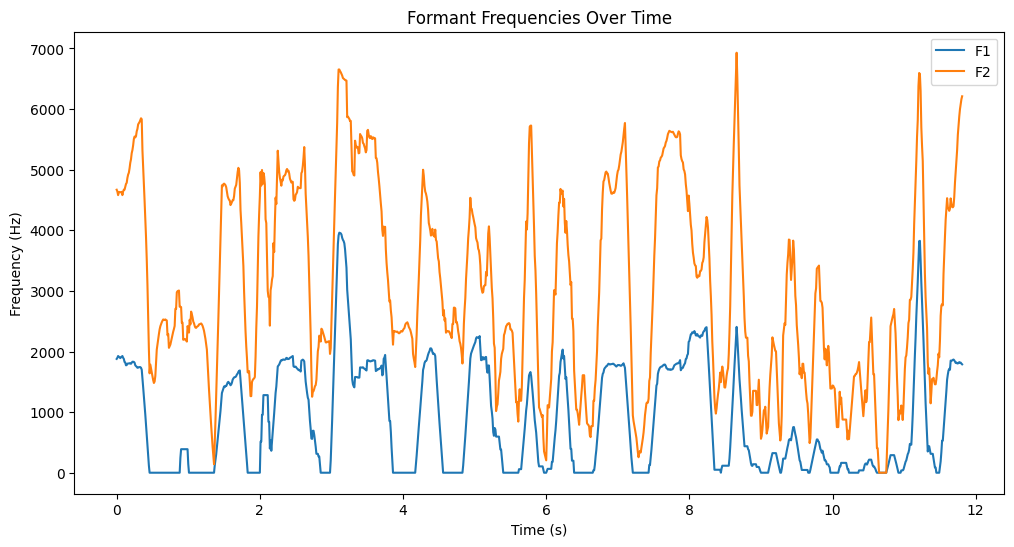

Vowel detected at times: [ 0.91  0.92  0.93  0.94  0.95  0.96  0.97  0.98  0.99  1.39  1.4   1.41
  1.8   1.81  2.14  2.71  2.72  2.73  2.74  2.75  2.76  2.77  2.78  2.79
  2.8   2.81  2.82  2.83  3.    4.19  4.85  5.27  5.28  5.29  5.3   5.31
  5.32  5.33  5.34  5.35  5.36  5.37  5.38  5.67  5.68  5.87  5.88  6.69
  6.7   6.71  6.72  7.18  7.19  7.47  8.32  8.33  8.34  8.78  8.79  8.8
  8.81  8.82  8.83  8.84  9.15  9.16  9.17  9.18  9.19  9.2   9.21  9.22
  9.5   9.51  9.52  9.53  9.73  9.74  9.87  9.88 10.81 10.82 11.04 11.05
 11.06 11.32 11.33 11.34 11.35 11.36 11.37 11.38 11.39 11.4 ]


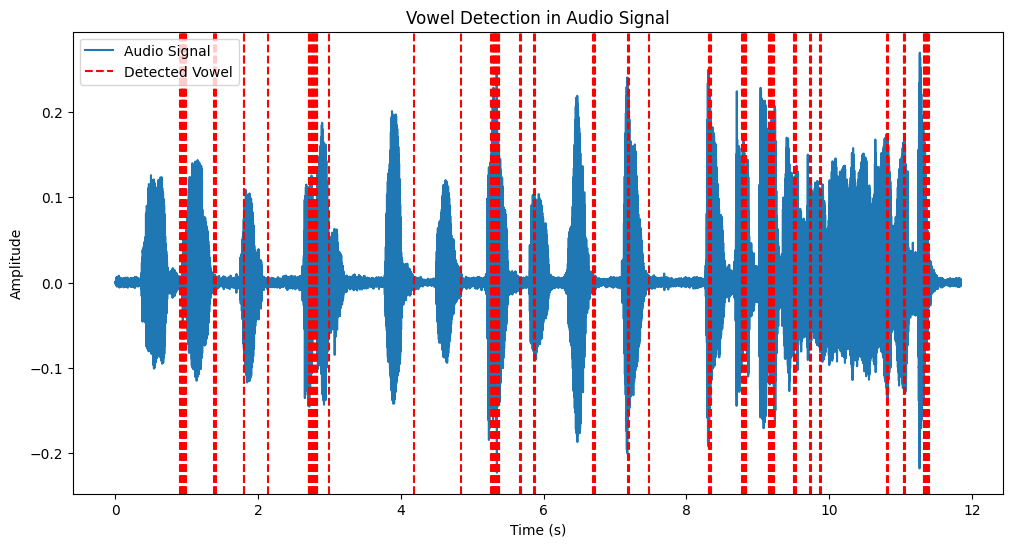

In [ ]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import lfilter, get_window

def pre_emphasis(signal, pre_emphasis_coeff=0.97):
    return np.append(signal[0], signal[1:] - pre_emphasis_coeff * signal[:-1])

def framing(signal, frame_size, hop_size):
    num_frames = 1 + int((len(signal) - frame_size) / hop_size)
    frames = np.stack([signal[i * hop_size:i * hop_size + frame_size] for i in range(num_frames)])
    return frames

def windowing(frames, window_func=get_window):
    window = window_func('hamming', frames.shape[1])
    return frames * window

def formant_extraction(frame, sr, lpc_order=12):
    lpc_coeffs = librosa.lpc(frame, order=lpc_order)
    roots = np.roots(lpc_coeffs)
    roots = [r for r in roots if np.imag(r) >= 0]
    angles = np.angle(roots)
    freqs = sorted(angles * (sr / (2 * np.pi)))
    return freqs[:2] if len(freqs) >= 2 else [0, 0]

def smooth(data, window_len=11):
    if window_len < 3:
        return data
    s = np.r_[data[window_len-1:0:-1], data, data[-2:-window_len-1:-1]]
    w = np.ones(window_len, 'd')
    y = np.convolve(w/w.sum(), s, mode='valid')
    return y[:len(data)]

def vowel_detection(audio_path, frame_size=0.025, hop_size=0.01, pre_emphasis_coeff=0.97):
    signal, sr = librosa.load(audio_path, sr=None)
    emphasized_signal = pre_emphasis(signal, pre_emphasis_coeff)
    frame_size_samples = int(frame_size * sr)
    hop_size_samples = int(hop_size * sr)
    frames = framing(emphasized_signal, frame_size_samples, hop_size_samples)
    windowed_frames = windowing(frames)

    f1_list, f2_list = [], []
    times = librosa.frames_to_time(np.arange(len(windowed_frames)), sr=sr, hop_length=hop_size_samples)
    for frame in windowed_frames:
        f1, f2 = formant_extraction(frame, sr)
        f1_list.append(f1)
        f2_list.append(f2)

    f1_array = smooth(np.array(f1_list))
    f2_array = smooth(np.array(f2_list))

    min_len = min(len(times), len(f1_array), len(f2_array))
    times = times[:min_len]
    f1_array = f1_array[:min_len]
    f2_array = f2_array[:min_len]

    plt.figure(figsize=(12, 6))
    plt.plot(times, f1_array, label='F1')
    plt.plot(times, f2_array, label='F2')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.title('Formant Frequencies Over Time')
    plt.legend()
    plt.show()

    vowel_indices = np.where((f1_array > 250) & (f1_array < 800) & (f2_array > 850) & (f2_array < 2500))[0]
    vowel_times = times[vowel_indices]

    return vowel_times, signal, sr

def plot_vowel_detection(vowel_times, signal, sr):
    times = np.arange(len(signal)) / sr
    plt.figure(figsize=(12, 6))
    plt.plot(times, signal, label='Audio Signal')
    for vt in vowel_times:
        plt.axvline(x=vt, color='r', linestyle='--', label='Detected Vowel' if vt == vowel_times[0] else "")
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title('Vowel Detection in Audio Signal')
    plt.legend()
    plt.show()

audio_path = '/content/20 Jul, 7.04 pm_.wav'
vowel_times, signal, sr = vowel_detection(audio_path)
print('Vowel detected at times:', vowel_times)
plot_vowel_detection(vowel_times, signal, sr)


In [ ]:
!pip install librosa numpy matplotlib scipy
